### Edgar Moises Hernandez-Gonzalez
#### 14/05/20-03/07/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D + LSTM
##### Caracteristicas = Escalogramas CWT (3D)
##### Entrada resize proporcional de 495x500
##### Validacion cruzada

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pywt
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from keras.models import Sequential
from keras.layers import (TimeDistributed, Conv2D, MaxPool2D, Flatten, LSTM,
                          Dense)
from keras.optimizers import Adam
# from keras.callbacks import ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [4]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [5]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/MI-EEG-A09T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/MI-EEG-A09E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/EtiquetasA09T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/EtiquetasA09E.csv", header=None)

In [6]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [7]:
x = pd.concat([x_train, x_test])
y = pd.concat([y_train, y_test])

In [8]:
print(x.shape)
print(y.shape)

(576, 22000)
(576, 1)


In [9]:
# en caso de no tener el y_test se puede utilizar el x_test
n_samples = len(y)

print("n_samples:", n_samples)

n_samples: 576


In [10]:
# esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test
n_classes = len(np.unique(y))

print("n_classes:", n_classes)

n_classes: 4


In [11]:
# codificar etiquetas con valores de 0 a nClases-1
y = LabelEncoder().fit_transform(y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
#unir 22 canales
def unir_escalogramas_vertical(data):
  dim = (500, 495) #ancho, alto
  fs = 250
  escalas = pywt.scale2frequency('cmor3-3', np.arange(8,30.5,0.5)) / (1/fs)
  datos = np.zeros((data.shape[0],495,500))
  temporal = np.zeros((990,1000))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      #sig = sig[124:624]
      # escalograma CWT
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3', sampling_period = (1 / fs))
      temporal[j*45:(j+1)*45, :] = abs(coef)
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [13]:
# unir_escalogramas_vertical_resize(data):
inicio = time.time()

x = unir_escalogramas_vertical(x)

fin = time.time()
print("Tiempo:", fin - inicio)

0
100
200
300
400
500
Tiempo: 192.31492257118225


In [14]:
print(x.shape)

(576, 495, 500)


In [15]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

90.57839317507704
0.01027021693911645
3.806500392162364


In [16]:
#convertir a float
x = x.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x /= np.ceil(np.max(x))

In [17]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

0.99536693
0.000112859525
0.0418297


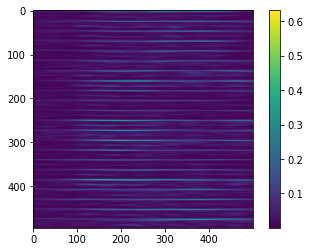

In [18]:
plt.figure()
plt.imshow(x[0])
plt.colorbar()
plt.show()

In [19]:
#convertir de 3D a 5D
x = x.reshape((x.shape[0], 1, x.shape[1], x.shape[2], 1))

print(x.shape)

(576, 1, 495, 500, 1)


In [20]:
# mc = ModelCheckpoint('/content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_CNN2D_LSTM_CWT09_CV.hdf5',
#                     monitor='val_accuracy', save_best_only=True, verbose=1)

In [21]:
skf = StratifiedKFold(n_splits = 10)

In [22]:
def CNN_2D_LSTM_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32, activation='tanh', dropout=0.5))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model


Iteration: 1
loss:  0.8493366899161503
accuracy:  0.7758620977401733
kappa:  0.7003179650238474
confusion matrix:
 [[15  0  0  0]
 [ 6  8  0  0]
 [ 3  1 10  0]
 [ 0  2  1 12]]


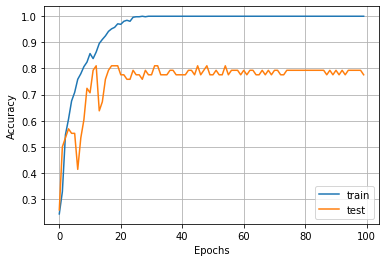

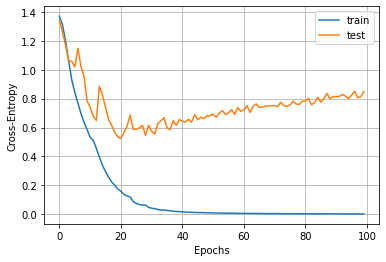


Iteration: 2
loss:  0.5328522591755308
accuracy:  0.8620689511299133
kappa:  0.8160919540229885
confusion matrix:
 [[14  1  0  0]
 [ 0 12  1  1]
 [ 0  2 11  1]
 [ 0  2  0 13]]


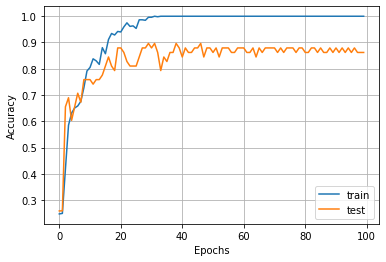

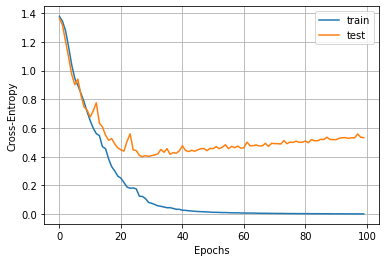


Iteration: 3
loss:  0.4448330186564347
accuracy:  0.8620689511299133
kappa:  0.816383062920459
confusion matrix:
 [[14  0  0  0]
 [ 0 13  1  0]
 [ 1  2 12  0]
 [ 0  3  1 11]]


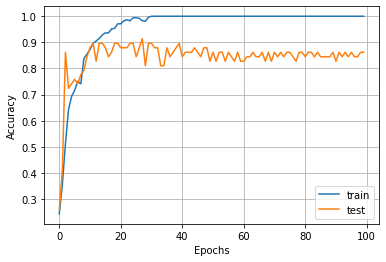

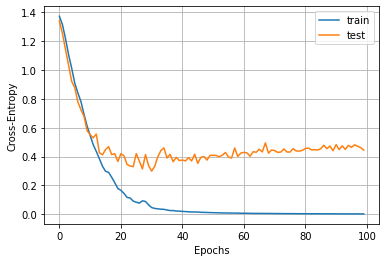


Iteration: 4
loss:  0.8395928802161381
accuracy:  0.7931034564971924
kappa:  0.7234803337306317
confusion matrix:
 [[10  1  2  1]
 [ 0 10  2  2]
 [ 0  2 11  2]
 [ 0  0  0 15]]


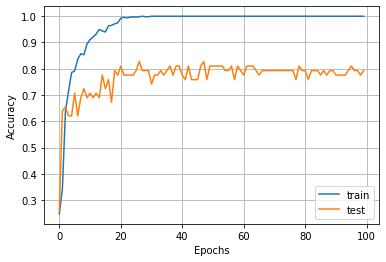

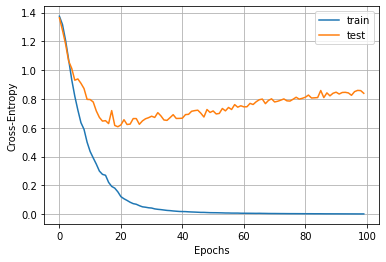


Iteration: 5
loss:  0.8842011279073255
accuracy:  0.7758620977401733
kappa:  0.7017405063291139
confusion matrix:
 [[13  0  1  0]
 [ 1  8  3  3]
 [ 1  1 11  2]
 [ 1  0  0 13]]


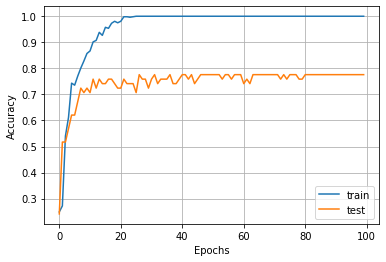

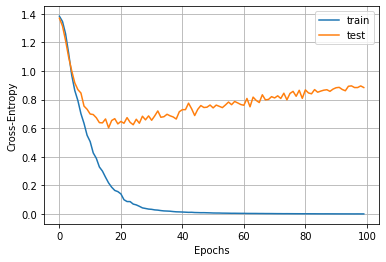


Iteration: 6
loss:  0.3765818281420346
accuracy:  0.8793103694915771
kappa:  0.8390166534496432
confusion matrix:
 [[14  0  0  0]
 [ 1 13  1  0]
 [ 0  4 11  0]
 [ 0  1  0 13]]


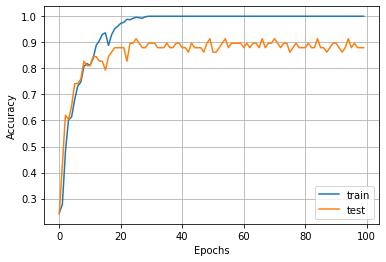

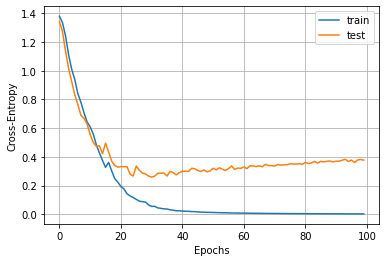


Iteration: 7
loss:  0.22916910679716812
accuracy:  0.9122806787490845
kappa:  0.8829087921117502
confusion matrix:
 [[14  0  0  0]
 [ 0 14  0  1]
 [ 0  0 13  1]
 [ 0  3  0 11]]


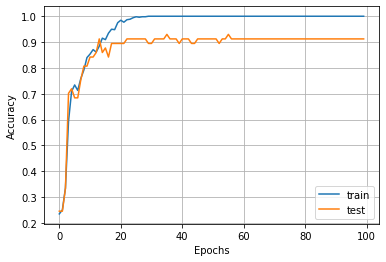

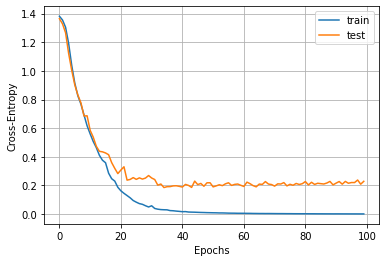


Iteration: 8
loss:  0.8453673814472399
accuracy:  0.8070175647735596
kappa:  0.7428219852337982
confusion matrix:
 [[12  2  0  0]
 [ 4  9  1  1]
 [ 0  0 13  1]
 [ 0  2  0 12]]


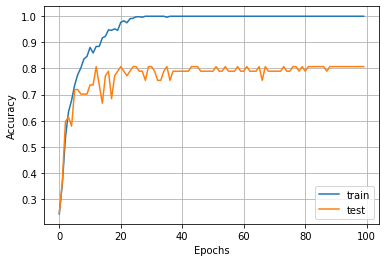

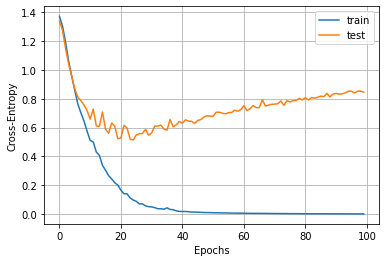


Iteration: 9
loss:  0.3033615544176938
accuracy:  0.9298245906829834
kappa:  0.9063655030800821
confusion matrix:
 [[15  0  0  0]
 [ 1 10  2  1]
 [ 0  0 14  0]
 [ 0  0  0 14]]


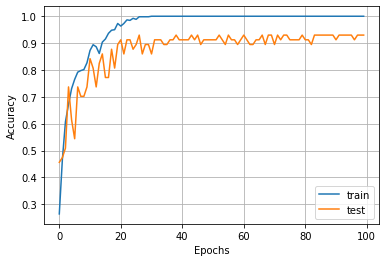

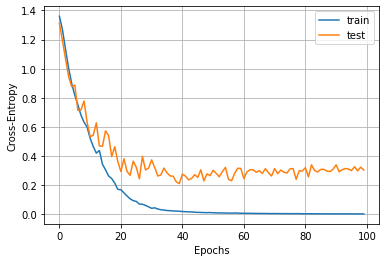


Iteration: 10
loss:  0.7442699597592939
accuracy:  0.7719298005104065
kappa:  0.6963114754098361
confusion matrix:
 [[11  1  3  0]
 [ 0 11  3  0]
 [ 0  3  8  3]
 [ 0  0  0 14]]


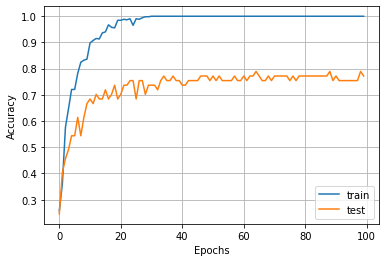

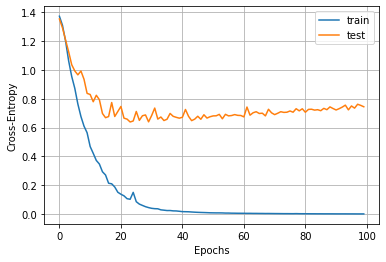


Resultados:
loss: [0.8493366899161503, 0.5328522591755308, 0.4448330186564347, 0.8395928802161381, 0.8842011279073255, 0.3765818281420346, 0.22916910679716812, 0.8453673814472399, 0.3033615544176938, 0.7442699597592939]
accuracy: [0.7758620977401733, 0.8620689511299133, 0.8620689511299133, 0.7931034564971924, 0.7758620977401733, 0.8793103694915771, 0.9122806787490845, 0.8070175647735596, 0.9298245906829834, 0.7719298005104065]
kappa: [0.7003179650238474, 0.8160919540229885, 0.816383062920459, 0.7234803337306317, 0.7017405063291139, 0.8390166534496432, 0.8829087921117502, 0.7428219852337982, 0.9063655030800821, 0.6963114754098361]
Tiempo: 1186.7830047607422


In [23]:
inicio = time.time()
array_loss = []
array_acc = []
array_kappa = []
i = 0
for iTrain, jTest in skf.split(x, y):
  print("\nIteration:", i + 1)
  x_train, x_test = x[iTrain], x[jTest]
  y_train, y_test = y[iTrain], y[jTest]

  model = CNN_2D_LSTM_TD()
  
  history = model.fit(x_train, y_train, epochs=100, batch_size=36,
                      validation_data=(x_test, y_test), verbose=0)

  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
  i += 1
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
fin = time.time()
tiempo = fin - inicio
print("Tiempo:", tiempo)

In [24]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_46 (TimeDis (None, 1, 495, 500, 16)   160       
_________________________________________________________________
time_distributed_47 (TimeDis (None, 1, 247, 250, 16)   0         
_________________________________________________________________
time_distributed_48 (TimeDis (None, 1, 247, 250, 16)   2320      
_________________________________________________________________
time_distributed_49 (TimeDis (None, 1, 123, 125, 16)   0         
_________________________________________________________________
time_distributed_50 (TimeDis (None, 1, 246000)         0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                31492224  
_________________________________________________________________
dense_19 (Dense)             (None, 256)             

In [25]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))
print("Tiempo:", int(tiempo))

Mean Accuracy: 0.8369
std: (+/- 0.0565)
Mean Kappa: 0.7825
std: (+/- 0.0753)
Max Accuracy: 0.9298
Max Kappa: 0.9064
Tiempo: 1186


In [26]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jul  3 21:30:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    50W / 250W |   9253MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------